## CKY parser implementation

In [ ]:
import nltk
import random

In [2]:
tree = nltk.Tree.fromstring('(S (NP (Det the)(Nom (N batter))) (VP (VP (V hit)) (NP (Det the)(Nom (N ball))) (PP (Prep with) (NP (Det the) (Nom (N bat))))))')

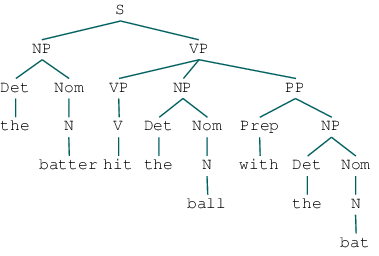

In [3]:
tree

In [4]:
#tree.draw()

In [20]:
Grammar = nltk.CFG.fromstring("""S -> NP VP | VP NP
                                 NP -> Det Nom | Det Nom PP | PropNoun | Pronoun
                                 Nom -> Nom N | N
                                 VP -> VP NP | V NP PP | VP PP | V
                                 PP -> Prep NP
                                 Det -> 'a' | 'the' | 'this' | 'The'
                                 N -> 'ball' | 'bat' | 'base' | 'wall' | 'glove' | 'field' | 'batter'
                                 PropNoun -> 'Pittsburgh' | 'Cleveland'
                                 Pronoun -> 'I' | 'you' | 'it'
                                 Prep -> 'to' | 'on' | 'over' | 'with' | 'from'
                                 V -> 'is' | 'hit' | 'run' | 'catch'""")

In [21]:
parser = nltk.ChartParser(Grammar)
sentence = 'The batter hit the ball with the bat'
words = nltk.word_tokenize(sentence)
trees = list(parser.parse(words))
tree2 = trees[0]

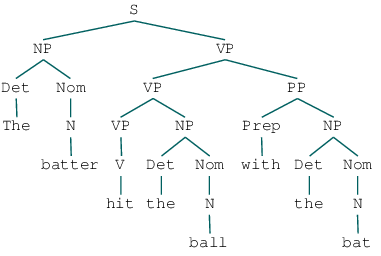

In [22]:
tree2

In [23]:
tree2.pprint()

(S
  (NP (Det The) (Nom (N batter)))
  (VP
    (VP (VP (V hit)) (NP (Det the) (Nom (N ball))))
    (PP (Prep with) (NP (Det the) (Nom (N bat))))))


In [24]:
tree = nltk.Tree.fromstring('(S (NP (Det the) (Nom (N glove)) (PP (Prep on) (NP (Det the) (Nom (N field)))))(VP (VP (V is)) (PP (Prep from) (NP (PropN Pittsburgh)))))')

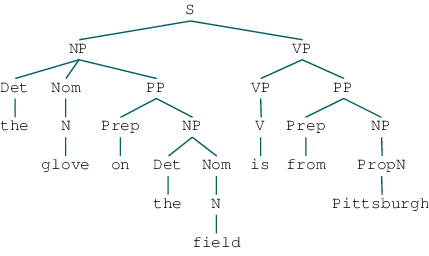

In [25]:
tree

In [26]:
tree3 = nltk.Tree.fromstring('(S)')
tree3

In [27]:
def height(tree):
    """
    Function that recursively finds the height of the tree.
    Parameters:
          tree: nltk tree
    Return value:
            height of tree
    """
    max_height = -1
    for child in tree:
        if not isinstance(child, nltk.Tree):
            max_height = max(max_height, 0)
        else:
            max_height = max(max_height, child.height())
    return max_height+1

In [28]:
height(tree2)
#height(tree3) # single node tree

7

In [14]:
tree3.height() # nltk method

1

##  Make grammar

In [15]:
def makeTreebankGrammar(numSents):
    """
    Generates a grammar from a given number of treebank sentences. Uses nltk's builtin treebank
    Parameters:
        numSents: integer indicating the first x number of sentences of the treebank to be used to 
                  make the grammar
    Return:
        a CFG grammar object
    """
    tb = nltk.corpus.treebank
    prodCounts= {}
    for sent in tb.parsed_sents()[:numSents]:
        prod = sent.productions()
        for rule in prod:
            if rule not in prodCounts:
                prodCounts[rule] = 0
            prodCounts[rule] += 1
    gram = [rule for rule in prodCounts if prodCounts[rule] > 1]
    
    return nltk.grammar.CFG(nltk.grammar.Nonterminal('S'), gram)

In [16]:
print(makeTreebankGrammar(20))

Grammar with 136 productions (start state = S)
    S -> NP-SBJ VP .
    NP -> NNP NNP
    NNP -> 'Vinken'
    , -> ','
    ADJP -> NP JJ
    NP -> CD NNS
    NNS -> 'years'
    JJ -> 'old'
    NP -> DT NN
    DT -> 'the'
    PP-CLR -> IN NP
    NP -> DT JJ NN
    DT -> 'a'
    JJ -> 'nonexecutive'
    NN -> 'director'
    . -> '.'
    NP-SBJ -> NNP NNP
    VP -> VBZ NP-PRD
    VBZ -> 'is'
    NP-PRD -> NP PP
    NP -> NN
    NN -> 'chairman'
    PP -> IN NP
    IN -> 'of'
    NP -> NP , NP
    NN -> 'group'
    CC -> 'and'
    NP -> NP PP
    NP -> JJ NN
    VP -> VBD VP
    VBD -> 'was'
    VP -> VBN S
    NP-SBJ -> -NONE-
    -NONE- -> '*-1'
    S -> S-TPC-1 , NP-SBJ VP .
    S-TPC-1 -> NP-SBJ VP
    DT -> 'A'
    NN -> 'asbestos'
    ADVP-TMP -> RB
    VBN -> 'used'
    NP -> -NONE-
    -NONE- -> '*'
    VP -> TO VP
    TO -> 'to'
    NNP -> 'Kent'
    NN -> 'cigarette'
    NNS -> 'filters'
    VP -> VBN NP
    NN -> 'percentage'
    NN -> 'cancer'
    NNS -> 'deaths'
    PP-LOC -> 

## Generate random sentences with grammar

In [17]:
gram = makeTreebankGrammar(50)

In [54]:
def randomSentence(grammar, start):
    """ 
    Recursively generates a random sentence from the given grammar, starting with the given start symbol.
    Parameters:
        grammar: a CFG grammar object
        start: the production symbol of the grammar
    Return:
        sentence: a string sentence randomly generated from the grammar
    """
    sentence = ''
    
    pickProd = random.choice(grammar.productions(lhs = start))
    for prod in pickProd.rhs():
        #print(grammar.productions(lhs=prod))
        if grammar.productions(lhs = prod):
            #print(grammar.productions(lhs = prod))
            sentence += randomSentence(grammar, prod)
        else:
            if type(prod) == str:
                sentence += str(prod) + ' '
    return sentence

In [65]:
randomSentence(gram, gram.start())

'is maturity including $ three 400 factory , *T*-1 sold some three nonexecutive yields * asbestos-related . '

## CKY parsing algorithm

In [1]:
# Assumes grammar is in CNF
# Simplified version - only generates one parse tree,
# may not work on grammars with productions with identical RHS's

import nltk

def cky_parse(sentence, grammar):
    words = nltk.word_tokenize(sentence)
    numWords = len(words)

    table = [[[] for row in range(numWords + 1)] for column in range(numWords + 1)]
    s = [[[] for row in range(numWords + 1)] for column in range(numWords + 1)]

    for j in range(1, numWords + 1):
        productions = grammar.productions(rhs = words[j - 1])
        for i in range(0,len(productions)):
            table[j - 1][j].append((productions[i].lhs()))
            
    for span in range(2, numWords + 1):
        for i in range(numWords - span + 1):
            j = i + span
            for k in range(i + 1, j):
                for production in grammar.productions():  # could use an inverted dict
                    for indexOne in range(len(table[i][k])):
                        for indexTwo in range(len(table[k][j])):
                            if production.rhs() == (table[i][k][indexOne], table[k][j][indexTwo]):
                                table[i][j].append(production.lhs())
                                s[i][j].append((k,indexOne, indexTwo))
    return table, s

In [67]:
def backtrack(table, s, words, i, j,m):
    nt = str(table[i][j][m])
    if j == i + 1:
        return '(' + nt + ' ' + words[i] + ')'
    else:
        k,index1,index2 = s[i][j][m]
        return '(' + nt + ' ' + backtrack(table, s, words, i, k,index1) + ' ' + backtrack(table, s, words, k, j,index2) + ')'

In [68]:
def getParseTree(table, s, sentence):
    words = nltk.word_tokenize(sentence)
    numWords = len(words)
    lister = []
    for each in range(len(table[0][numWords])):
        if str(table[0][numWords][each]) == 'S':
            lister.append(backtrack(table, s, words, 0, numWords,each))
        else:
            lister.append('')
    return lister

In [69]:
def display(table):
    print('\n     ' + ' '.join(['{:<11d}'.format(i) for i in range(1, len(table))]))
    print('     ' + ' '.join(['-' * 11 for i in range(1, len(table))]))
    for i in range(len(table) - 1):
        print('{:<3d}|'.format(i), end=' ')
        for j in range(1, len(table)):
            print('{:<11s}'.format(str(table[i][j])), end=' ')
        print()

In [71]:
def main():
    sentence = 'I hit the ball with a bat to the wall'

    grammar = nltk.CFG.fromstring("""S -> NP VP
                                     NP -> Det Nom | DT PP
                                     DT -> Det Nom
                                     Nom -> Nom Nom
                                     VP -> VP NP | VNP PP | VP PP
                                     VNP -> VP NP
                                     PP -> Prep NP
                                     Det -> 'a' | 'the' | 'this'
                                     Nom -> 'ball' | 'bat' | 'base' | 'wall' | 'glove' | 'field'
                                     NP -> 'Pirates' | 'Indians'
                                     NP -> 'I' | 'you' | 'it'
                                     Prep -> 'to' | 'on' | 'over' | 'with'
                                     VP -> 'hit' | 'run' | 'catch'""")

    table, s = cky_parse(sentence, grammar)
    display(table)
    display(s)
    print()
    
    trees = getParseTree(table, s, sentence)
    for tree in trees:
        nltk.Tree.fromstring(tree).draw()
main()


     1           2           3           4           5           6           7           8           9           10         
     ----------- ----------- ----------- ----------- ----------- ----------- ----------- ----------- ----------- -----------
0  | [NP]        [S]         []          [S]         []          []          [S, S, S]   []          []          [S, S, S, S, S, S, S] 
1  | []          [VP]        []          [VP, VNP]   []          []          [VP, VNP, VP, VP] []          []          [VP, VNP, VP, VP, VP, VP, VP, VP] 
2  | []          []          [Det]       [NP, DT]    []          []          [NP]        []          []          [NP]        
3  | []          []          []          [Nom]       []          []          []          []          []          []          
4  | []          []          []          []          [Prep]      []          [PP]        []          []          [PP]        
5  | []          []          []          []          []          [Det]       [NP,